# Lab 7 - hyperparameter tuning job and compare the metrics

In [1]:
import pandas as pd
import requests
import zipfile
import io
from scipy.io import arff
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import warnings
import os
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [2]:
%%time
f_zip = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip'
r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(io.BytesIO(r.content))
Vertebral_zip.extractall()
data = arff.loadarff('column_2C_weka.arff')
df = pd.DataFrame(data[0])
class_mapper = {b'Abnormal':1,b'Normal':0}
df['class']=df['class'].replace(class_mapper)
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['class'])
model = XGBClassifier(objective='binary:logistic', eval_metric='auc', num_round=42)
print(model.fit(train.drop(['class'], axis = 1).values, train['class'].values))
print("Training Completed")

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, num_round=42, ...)
Training Completed
CPU times: user 194 ms, sys: 47.8 ms, total: 242 ms
Wall time: 397 ms


In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score


    
def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()
    
    
def plot_roc(test_labels, target_predicted_binary):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100
    
    
    print(f"Sensitivity or TPR: {Sensitivity}%")    
    print(f"Specificity or TNR: {Specificity}%") 
    print(f"Precision: {Precision}%")   
    print(f"Negative Predictive Value: {NPV}%")  
    print( f"False Positive Rate: {FPR}%") 
    print(f"False Negative Rate: {FNR}%")  
    print(f"False Discovery Rate: {FDR}%" )
    print(f"Accuracy: {ACC}%") 

    test_labels = test.iloc[:,0];
    print("Validation AUC", roc_auc_score(test_labels, target_predicted_binary) )

    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted_binary)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    
    ax2 = plt.gca().twinx()
    # ax2.plot(fpr, thresholds, markeredgecolor='r', linestyle='dashed', color='r')
    # ax2.set_ylabel('Threshold', color='r')
    valid_thresholds = thresholds[np.logical_and(~np.isnan(thresholds), ~np.isinf(thresholds))]
    ax2.set_ylim([valid_thresholds[-1], valid_thresholds[0]]) if valid_thresholds.size > 0 else None
    
    ax2.set_xlim([fpr[0], fpr[-1]])
    
    plt.show()
    

# Step 1: Getting model statistics

In [8]:
batch_X = test.iloc[:,1:];
predicted_probabilities = model.predict_proba(batch_X)
target_predicted = pd.DataFrame(predicted_probabilities[:, 1], columns=['class'])
def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)

print(target_predicted_binary.head(5))
test_labels = test.iloc[:,0]

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64


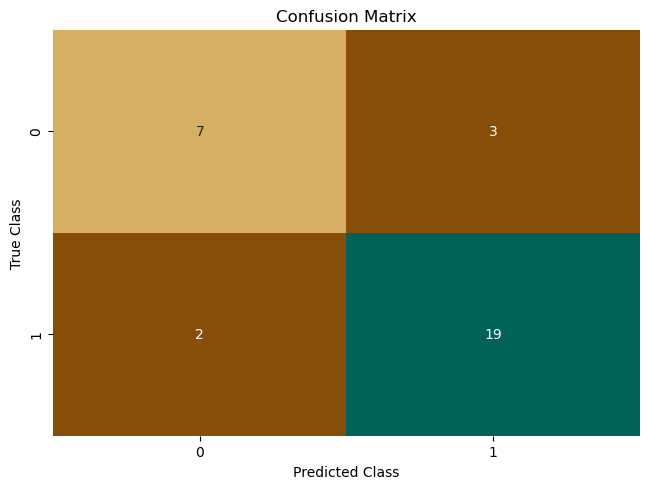

In [9]:
plot_confusion_matrix(test_labels, target_predicted_binary)

Sensitivity or TPR: 90.47619047619048%
Specificity or TNR: 70.0%
Precision: 86.36363636363636%
Negative Predictive Value: 77.77777777777779%
False Positive Rate: 30.0%
False Negative Rate: 9.523809523809524%
False Discovery Rate: 13.636363636363635%
Accuracy: 83.87096774193549%
Validation AUC 0.8023809523809523


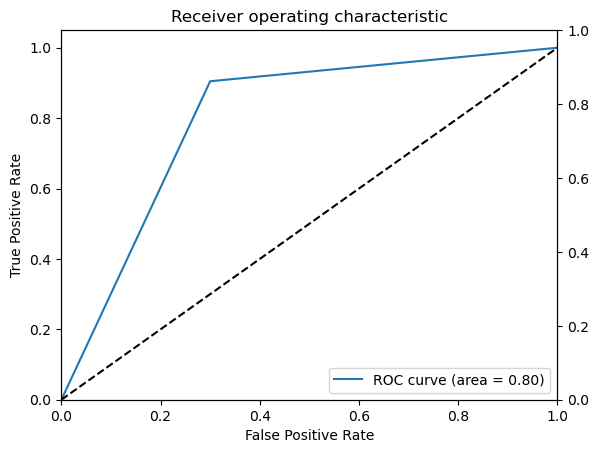

In [10]:
plot_roc(test_labels, target_predicted_binary)

## Step 2: Creating a hyperparameter tuning job

In [11]:
%%time
from sklearn.model_selection import RandomizedSearchCV
# Define your XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='error@.40',
                              objective='binary:logistic')

# Define hyperparameter ranges
hyperparameter_ranges = {'alpha': [i for i in range(0, 101)],
                         'min_child_weight': [i for i in range(1, 6)],
                         'subsample': [i / 10 for i in range(5, 11)],
                         'eta': [i / 10 for i in range(1, 4)]}

search = RandomizedSearchCV(estimator=xgb_model,
                            param_distributions=hyperparameter_ranges,
                            scoring='neg_mean_squared_error',
                            n_iter=10,  # Number of parameter settings that are sampled
                            cv=5,       # Number of folds for cross-validation
                            verbose=1,
                            n_jobs=1)  # Use all available cores

search.fit(train.drop(['class'], axis = 1).values, train['class'].values)
best_params = search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 2.62 s, sys: 653 ms, total: 3.28 s
Wall time: 442 ms


In [12]:
best_params

{'subsample': 0.8, 'min_child_weight': 4, 'eta': 0.3, 'alpha': 16}

## Step 3: Investigating the Best Parameters tuning results

In [13]:
# Retrieve the results of RandomizedSearchCV
cv_results = pd.DataFrame(search.cv_results_)

# Sort the results by mean_test_score (or other relevant metric)
cv_results.sort_values(by='mean_test_score', ascending=False, inplace=True)

# Display the top 20 models
top_models = cv_results.head(20)
print(top_models[['params', 'mean_test_score']])

# Get the best hyperparameters
best_params = search.best_params_
print("Best Hyperparameters:", best_params)

# Create an XGBoost model with the best hyperparameters
best_xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='error', **best_params)

# Train the model with the best hyperparameters
best_xgb_model.fit(train.drop(['class'], axis = 1).values, train['class'].values)


                                              params  mean_test_score
2  {'subsample': 0.8, 'min_child_weight': 4, 'eta...        -0.165224
5  {'subsample': 0.9, 'min_child_weight': 1, 'eta...        -0.165469
7  {'subsample': 0.9, 'min_child_weight': 5, 'eta...        -0.173224
9  {'subsample': 0.6, 'min_child_weight': 4, 'eta...        -0.173388
0  {'subsample': 0.6, 'min_child_weight': 4, 'eta...        -0.322612
1  {'subsample': 0.7, 'min_child_weight': 4, 'eta...        -0.322612
3  {'subsample': 0.9, 'min_child_weight': 4, 'eta...        -0.322612
4  {'subsample': 1.0, 'min_child_weight': 2, 'eta...        -0.322612
6  {'subsample': 0.7, 'min_child_weight': 1, 'eta...        -0.322612
8  {'subsample': 0.6, 'min_child_weight': 2, 'eta...        -0.322612
Best Hyperparameters: {'subsample': 0.8, 'min_child_weight': 4, 'eta': 0.3, 'alpha': 16}


XGBClassifier(alpha=16, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric='error',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)

In [14]:
batch_X = test.iloc[:,1:];
predicted_probabilities = best_xgb_model.predict_proba(batch_X)
target_predicted = pd.DataFrame(predicted_probabilities[:, 1], columns=['class'])
def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

best_target_predicted_binary = target_predicted['class'].apply(binary_convert)
test_labels = test.iloc[:,0]

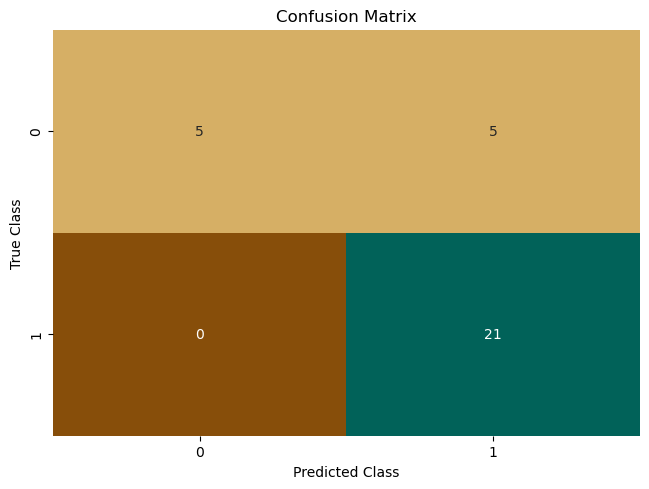

In [15]:
plot_confusion_matrix(test_labels, best_target_predicted_binary)

Sensitivity or TPR: 100.0%
Specificity or TNR: 50.0%
Precision: 80.76923076923077%
Negative Predictive Value: 100.0%
False Positive Rate: 50.0%
False Negative Rate: 0.0%
False Discovery Rate: 19.230769230769234%
Accuracy: 83.87096774193549%
Validation AUC 0.75


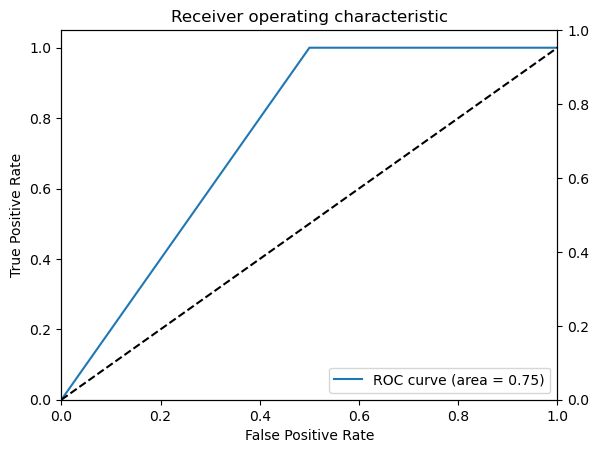

In [16]:
plot_roc(test_labels, best_target_predicted_binary)